作业一：文本数据处理（必做）

1.数据集：使用AI Studio平台作业项目中的/datasets/text中的数据集。

2.要求：
1) 去除所有标点符号；
2) 将预料中所有的大写英文字符全部转化为小写；
3) 将文本中的内容转化为独立的词汇，并统计每个词汇出现的频次，根据频次设置唯一ID；
4) 将语料转化为ID序列；
5) 使用二次采样算法处理预料，强化训练效果；
6) 使用skip-gram训练准备好的数据，得到最终的词表示向量；
7) 将拿到的词表示向量使用tsne、pca或者其他可视化的方法进行可视化表示，并将可视化得到的结果保存。

3.注意事项及要求：
1) 没必要使用完整的数据集，重点在如何处理文本数据上，可适当截取选择使用部分数据集。
2) 完成上面的所有操作，将结果保存到/results/text目录下。
3) 在代码中加上必要的注释。

作业二：图像数据处理（必做）

1.数据集：使用AI Studio平台作业项目中的/datasets/image中的数据集。

2.图像数据处理方式：
1) 使用高斯、瑞利、伽马、均匀和椒盐等噪声中的一种方法处理原图片，查看噪声处理图片后的效果；
2) 使用邻域平均法、中值滤波、最大值滤波、最小值滤波和高斯滤波等方法中的一种处理加过噪声后的图像，完成去噪声操作；
3) 使用RGB、GRAY（灰度图像）、XYZ、YCrC、HSV、HLS、CIELab*、CIELuv*或者Bayer等色彩空间处理第二步处理过的图像，如将RGB图像转化成GRAY灰度图像；
4) 将上面第三步得到的图片作为模型输入，使用普通CNN网络、ResNet或者VGG模型提取处理过程中的特征图，并将特征图保存。

3.注意事项及要求：
1) 没必要使用完整的数据集，重点在如何处理图像数据上，可适当截取选择使用部分数据集。
2) 完成上述的4步操作，将结果保存到/results/image目录下。
3) 在代码中加上必要的注释。

作业三：音频数据集数据处理（选做）

1.数据集：使用AI Studio平台作业项目中的/datasets/voice中的数据集。

2.请使用以下音频数据处理方式中的1-2种方法处理上述数据集，将结果保存到/results/voice目录下。
1) 降噪和去干扰 
2) 去混响 
3) 端点检测 
4) 音量归一化 
5) 异常检测和修复

3.注意事项及要求：
1) 没必要使用完整的数据集，重点在如何处理音频数据上，可适当截取选择使用部分数据集。
2) 在代码中加上必要的注释。

作业四：视频数据集数据处理（选做）

1.数据集：使用AI Studio平台作业项目中的/datasets/video中的数据集。

2.请使用以下视频数据处理方式中的1-2种方法处理上述数据集，将结果保存到/results/video目录下。
1) 使用时间滤波，对连续帧进行平均或加权平均 
2) 使用空间滤波中的高斯滤波对视频进行处理 
3) 使用空间滤波中的中值滤波对视频进行处理 

3.注意事项及要求：
1) 没必要使用完整的数据集，且视频数据的数据集较大，重点在如何处理视频数据上。
2) 在代码中加上必要的注释。

In [1]:
# 作业一：文本数据处理（必做）

# 1.数据集：使用AI Studio平台作业项目中的/datasets/text中的数据集。

# 2.要求：

# 去除所有标点符号；
# 将预料中所有的大写英文字符全部转化为小写；
# 将文本中的内容转化为独立的词汇，并统计每个词汇出现的频次，根据频次设置唯一ID；
# 将语料转化为ID序列；
# 使用二次采样算法处理预料，强化训练效果；
# 使用skip-gram训练准备好的数据，得到最终的词表示向量；
# 将拿到的词表示向量使用tsne、pca或者其他可视化的方法进行可视化表示，并将可视化得到的结果保存。

# 结果保存在/result/text中，运行程序会出现每次的Epoch

In [2]:
import re
import os
import numpy as np
import collections
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import paddle
from paddle.nn import Embedding
from paddle.optimizer import Adam
import random

In [3]:
# 读取数据并进行预处理
def preprocess_text(text):
    # 去除标点符号
    text = re.sub(r'[^\w\s]', '', text)
    # 转换为小写
    text = text.lower()
    # 分词
    words = text.split()
    return words

In [4]:
# 加载数据集
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return preprocess_text(text)

In [5]:
# 统计词频并为每个词分配唯一ID
def build_vocab(words):
    word_count = collections.Counter(words)
    word_to_id = {word: idx for idx, (word, _) in enumerate(word_count.items())}
    return word_to_id, word_count

In [6]:
# 将语料转化为ID序列
def text_to_id_sequence(words, word_to_id):
    return [word_to_id[word] for word in words if word in word_to_id]

In [7]:
# 二次采样算法
def subsampling(words, word_count, threshold=1e-5):
    total_count = sum(word_count.values())
    word_freq = {word: count / total_count for word, count in word_count.items()}
    sampled_words = [word for word in words if random.random() > (1 - np.sqrt(threshold / word_freq[word]))]
    return sampled_words

In [8]:
# 生成Skip-gram训练数据对
def generate_skipgram_data(id_sequence, window_size=2):
    data = []
    for i, center in enumerate(id_sequence):
        # 在窗口范围内选择上下文词
        context_indices = list(range(max(0, i - window_size), min(len(id_sequence), i + window_size + 1)))
        context_indices.remove(i)  # 去除中心词自身
        for context in context_indices:
            data.append((center, id_sequence[context]))
    return data

In [9]:
# 定义Skip-gram模型
class SkipGramModel(paddle.nn.Layer):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embed = Embedding(vocab_size, embedding_dim)  # 定义嵌入层
    
    def forward(self, center, context):
        center_emb = self.embed(center)  # 中心词嵌入
        context_emb = self.embed(context)  # 上下文词嵌入
        return center_emb, context_emb

In [10]:
# 训练Skip-gram模型
def train_skipgram(data, vocab_size, embedding_dim=100, epoch_num=10):
    model = SkipGramModel(vocab_size, embedding_dim)
    optimizer = Adam(parameters=model.parameters(), learning_rate=0.001)
    
    # 假设生成了训练数据对
    for epoch in range(epoch_num):
        for center, context in data:
            center = paddle.to_tensor([center])
            context = paddle.to_tensor([context])
            center_emb, context_emb = model(center, context)
            loss = paddle.nn.functional.cosine_embedding_loss(center_emb, context_emb, paddle.ones([1]))
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()
        print(f"Epoch {epoch+1}/{epoch_num}, Loss: {loss.numpy()}")

    return model.embed.weight.numpy()

In [11]:
# 可视化词向量
def visualize_embeddings(embeddings, word_to_id, words_to_visualize=100):
    words = list(word_to_id.keys())[:words_to_visualize]
    embeddings_to_plot = embeddings[:words_to_visualize]
    
    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings_to_plot)
    
    plt.figure(figsize=(14, 14))
    for i, word in enumerate(words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    plt.savefig('/home/aistudio/result/text/word_embeddings_visualization.png')
    plt.show()

In [12]:
# 主函数
def main():
    # 假设部分数据集路径
    file_path = '/home/aistudio/datasets/text/ccmt2019.txt'  # 使用实际数据路径
    text = load_data(file_path)
    
    # 构建词汇表并生成词ID
    word_to_id, word_count = build_vocab(text)
    
    # 将文本转化为ID序列
    id_sequence = text_to_id_sequence(text, word_to_id)
    
    # 使用二次采样算法进行处理
    sampled_words = subsampling(text, word_count)
    sampled_id_sequence = text_to_id_sequence(sampled_words, word_to_id)
    
    # 生成Skip-gram数据对
    skipgram_data = generate_skipgram_data(sampled_id_sequence)
    
    # 训练skip-gram模型
    vocab_size = len(word_to_id)
    word_embeddings = train_skipgram(skipgram_data, vocab_size)
    
    # 可视化
    visualize_embeddings(word_embeddings, word_to_id)

Epoch 1/10, Loss: 0.5819134712219238
Epoch 2/10, Loss: 0.32068783044815063
Epoch 3/10, Loss: 0.1717287302017212
Epoch 4/10, Loss: 0.07031935453414917
Epoch 5/10, Loss: 0.035407960414886475
Epoch 6/10, Loss: 0.011129558086395264
Epoch 7/10, Loss: 0.00599217414855957
Epoch 8/10, Loss: 0.0037341713905334473
Epoch 9/10, Loss: 0.0034984946250915527
Epoch 10/10, Loss: 0.0026567578315734863


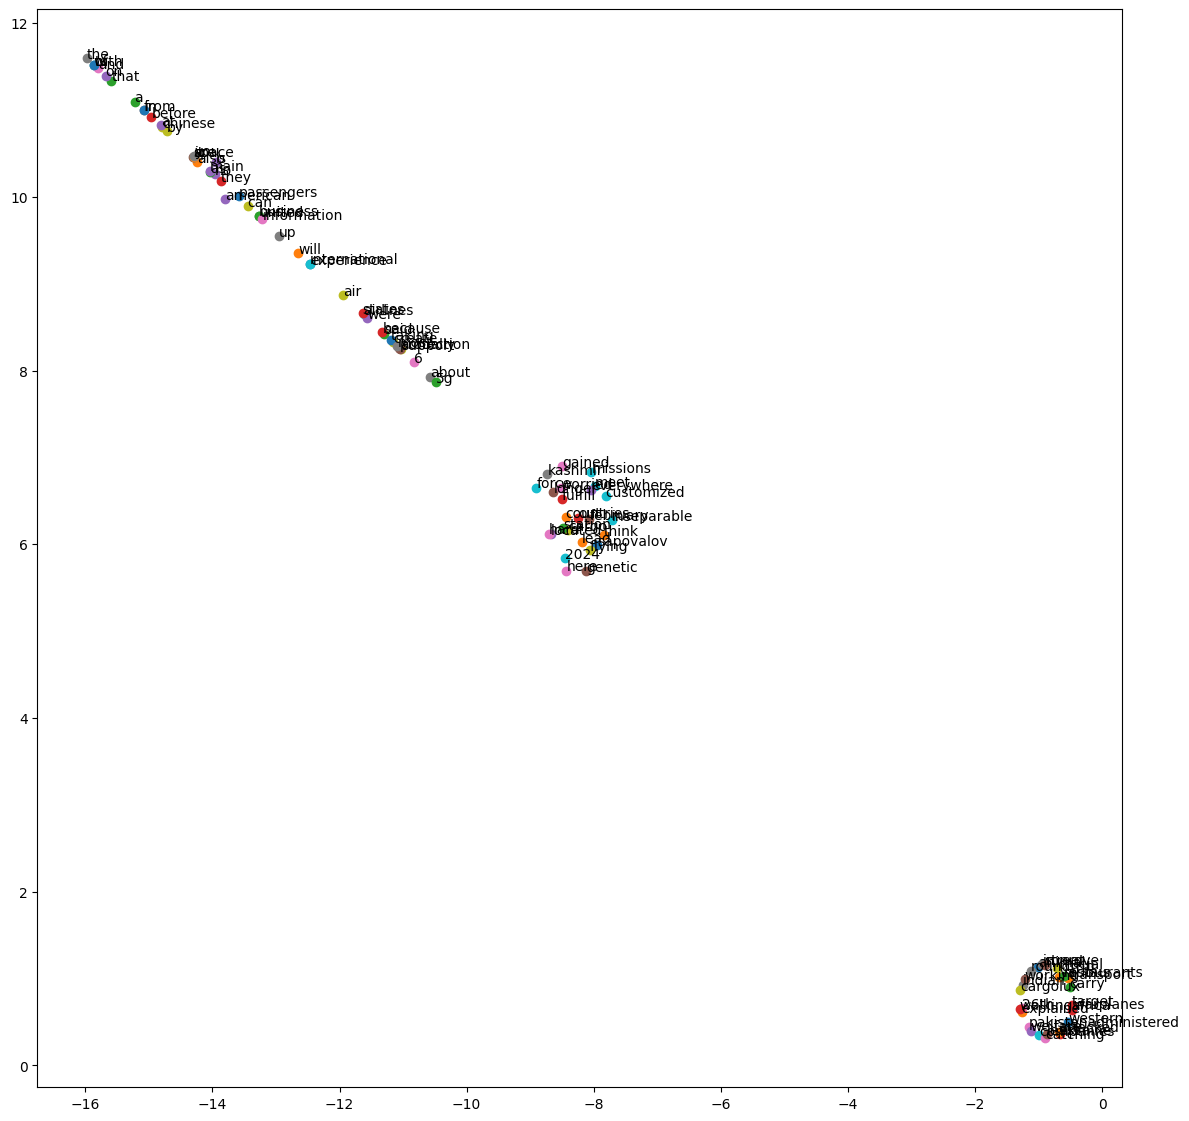

In [13]:
# 运行主程序
if __name__ == '__main__':
    main()